This notebook computes the learning outcomes from the pre-test and post-test responses.

We consider two learning goals:
* LG1: identify a (feasible) solution to the problem
* LG2: construct a correct (i.e. optimal) solution.
    
For LG1, we check connectedness, i.e. if solutions are spanning or not
out.

For LG2, we check optimality, i.e. how close was the solution to the correct solution, quantified by the error.

In [1]:
import math
import copy
import pickle

import pathlib as pl
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from scipy.stats import wilcoxon, shapiro, ttest_rel
from effsize.effsize import two_group_difference

In [2]:
sns.set_theme()
sns.set_context('paper', font_scale=1.5)

In [3]:
pd.options.display.max_rows = None

### Define paths.

In [4]:
transition_tables_pickle_file = pl.Path(
    '../processed_data/justhink21_transition_tables.pickle')

learning_file = pl.Path('../processed_data/justhink21_learning_outcomes.csv')

figs_dir = pl.Path('../figures')

# Create the output figures directory if it does not exist.
figs_dir.mkdir(exist_ok=True)

In [5]:
test_item_counts = {
    'pretest': 5,
    'posttest': 5,
}

### Load transition tables.

In [6]:
with transition_tables_pickle_file.open('rb') as handle:
    transition_tables = pickle.load(handle)

<!-- ### Cleaning tables. -->

### Fiter for the submissions.

In [7]:
def filter_submissions(transition_tables, verbose=False):
    """Get the submission states only, and drop the duplicates, 
    unused columns, keep state, activity, imported info."""
    tables = {}

    for participant in sorted(transition_tables):
        print('Filtering submissions for {}...'.format(participant))

        df = transition_tables[participant].copy()

        # Filter for the submission rows.
        df = df[df['is_submission']]

        # Remove duplicate rows from submission log and keeping the last submission
        df.drop_duplicates(subset='activity', keep='last', inplace=True)

        tables[participant] = df

        if verbose:
            display(df)

    print('Done!')

    return tables


submission_tables = filter_submissions(transition_tables)

# submission_tables[8]

Filtering submissions for 1...
Filtering submissions for 2...
Filtering submissions for 3...
Filtering submissions for 4...
Filtering submissions for 5...
Filtering submissions for 6...
Filtering submissions for 7...
Filtering submissions for 8...
Filtering submissions for 9...
Done!


### Count feasible and optimal solutions in the tests.

In [8]:
def count_feasible(df, test_name):
    """Count the number of feasible solutions given to a 
    pre-test or post-test."""
    count = 0
    for index, row in df.iterrows():
        if test_name in row['activity']:
            if row['is_spanning']:
                count = count + 1
    return count


def score_feasible(df, test_name, total_count):
    return count_feasible(df, test_name) / total_count


for participant, df in submission_tables.items():
    print('{:2.0f}: feasible scores: pre-test {}, post-test {}'.format(
        participant,
        score_feasible(df, 'pretest', test_item_counts['pretest']),
        score_feasible(df, 'posttest', test_item_counts['posttest'])))

 1: feasible scores: pre-test 1.0, post-test 1.0
 2: feasible scores: pre-test 0.8, post-test 1.0
 3: feasible scores: pre-test 1.0, post-test 1.0
 4: feasible scores: pre-test 0.8, post-test 1.0
 5: feasible scores: pre-test 1.0, post-test 0.8
 6: feasible scores: pre-test 1.0, post-test 0.8
 7: feasible scores: pre-test 0.4, post-test 0.0
 8: feasible scores: pre-test 1.0, post-test 1.0
 9: feasible scores: pre-test 1.0, post-test 1.0


In [9]:
def count_optimal(df, test_name):
    """Count the number of optimal solutions given to a 
    pre-test or post-test."""
    count = 0
    for index, row in df.iterrows():
        if test_name in row['activity']:
            if row['is_mst']:
                count = count + 1
    return count


def score_optimal(df, test_name, total_count):
    return count_optimal(df, test_name) / total_count


for participant, df in submission_tables.items():
    print('{:2.0f}: optimal scores: pre-test {}, post-test {}'.format(
        participant,
        score_optimal(df, 'pretest', test_item_counts['pretest']),
        score_optimal(df, 'posttest', test_item_counts['posttest'])))

 1: optimal scores: pre-test 0.4, post-test 0.8
 2: optimal scores: pre-test 0.0, post-test 0.8
 3: optimal scores: pre-test 0.2, post-test 1.0
 4: optimal scores: pre-test 0.0, post-test 0.0
 5: optimal scores: pre-test 0.0, post-test 0.0
 6: optimal scores: pre-test 0.0, post-test 0.0
 7: optimal scores: pre-test 0.2, post-test 0.0
 8: optimal scores: pre-test 0.0, post-test 0.0
 9: optimal scores: pre-test 0.8, post-test 0.8


### Compute average error in the tests.

In [10]:
def compute_average_error(df, test_name, total_count):
    """Compute average error for a test."""
    total_error = 0
    count = 0
    valid_count = 0
    for index, row in df.iterrows():
        error = row['error']
        if test_name in row['activity']:
            # not computing the error for submissions that are not feasible/spanning
            count = count + 1
            if not math.isnan(error):
                valid_count = valid_count + 1
                total_error = total_error + error

    # Validity check.
    if count != total_count:
        print('Log of {} does not match with the number of items in {}'.format(
            participant, test_name))
        print(count, total_count)
        raise ValueError

    # Compute average, handling if no valid responses.
    if valid_count > 0:
        average_error = total_error / total_count
    else:
        average_error = None
    return average_error


for participant, df in submission_tables.items():
    print('{:2.0f}: average errors: pre-test {}, post-test {}'.format(
        participant,
        compute_average_error(df, 'pretest', test_item_counts['pretest']),
        compute_average_error(df, 'posttest', test_item_counts['posttest'])))

 1: average errors: pre-test 0.16952380952380955, post-test 0.013333333333333332
 2: average errors: pre-test 0.31047619047619046, post-test 0.009523809523809523
 3: average errors: pre-test 0.040634920634920635, post-test 0.0
 4: average errors: pre-test 0.3898412698412698, post-test 0.3555555555555555
 5: average errors: pre-test 0.3003174603174603, post-test 0.16698412698412696
 6: average errors: pre-test 0.30984126984126986, post-test 0.14984126984126983
 7: average errors: pre-test 0.04, post-test None
 8: average errors: pre-test 0.9257142857142858, post-test 0.1034920634920635
 9: average errors: pre-test 0.013333333333333332, post-test 0.009523809523809523


### Make a learning outcomes table.

In [11]:
participants = sorted(submission_tables.keys())
tests = ['pretest', 'posttest']

learn_df = pd.DataFrame(index=participants)
learn_df.index.name = 'participant'
for test in tests:
    count = test_item_counts[test]
    learn_df['{}_feasible'.format(test)] = \
        [score_feasible(submission_tables[p], test, count)
         for p in learn_df.index]

for test in tests:
    count = test_item_counts[test]
    learn_df['{}_optimal'.format(test)] = \
        [score_optimal(submission_tables[p], test, count)
         for p in learn_df.index]

for test in tests:
    count = test_item_counts[test]
    learn_df['{}_error'.format(test)] = \
        [compute_average_error(submission_tables[p], test, count)
         for p in learn_df.index]

learn_df

,pretest_feasible,posttest_feasible,pretest_optimal,posttest_optimal,pretest_error,posttest_error
participant,,,,,,
1,1.0,1.0,0.4,0.8,0.169524,0.013333
2,0.8,1.0,0.0,0.8,0.310476,0.009524
3,1.0,1.0,0.2,1.0,0.040635,0.000000
4,0.8,1.0,0.0,0.0,0.389841,0.355556
5,1.0,0.8,0.0,0.0,0.300317,0.166984
6,1.0,0.8,0.0,0.0,0.309841,0.149841
7,0.4,0.0,0.2,0.0,0.040000,NaN
8,1.0,1.0,0.0,0.0,0.925714,0.103492
9,1.0,1.0,0.8,0.8,0.013333,0.009524


### Visualize feasible solutions in the tests.

In [12]:
# color_list = ['Pastel1', 'Pastel2', 'Paired', 'Accent',
#               'Dark2', 'Set1', 'Set2', 'Set3',
#               'tab10', 'tab20', 'tab20b', 'tab20c']
# color_list = iter(color_list
# palette = sns.color_palette('colorblind')
palette = sns.color_palette('bright')
color_list = list(palette)

colors = {p: color_list[p-1] for p in participants}
colors[8] = color_list[9]
# colors = dict()
# for p in participants:
#     if p == 5: # skip gray.
#         a = next(color_list) 
#     colors[p] = next(color_list)
    
colors

{1: (0.00784313725490196, 0.24313725490196078, 1.0),
 2: (1.0, 0.48627450980392156, 0.0),
 3: (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 4: (0.9098039215686274, 0.0, 0.043137254901960784),
 5: (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 6: (0.6235294117647059, 0.2823529411764706, 0.0),
 7: (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 8: (0.0, 0.8431372549019608, 1.0),
 9: (1.0, 0.7686274509803922, 0.0)}

../figures/learning_outcomes_is_feasible.pdf


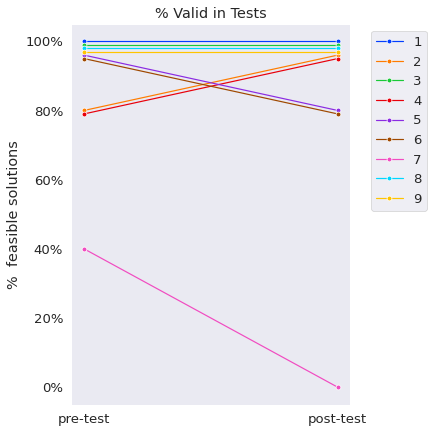

In [13]:
def plot_pretest_posttest(
        learn_df, getter, participants=None,
        fig=None, ax=None, offset=0.01,
        zero_offset=0,
        ylabel='', title='', filename=None,
        ylim=(-0.05, 1.05), ygrid=False, save=True,
        yticks=False, verbose=False):
    """Graph the pretest versus posttest is_spanning scores"""
    if participants is None:
        participants = sorted(learn_df.index)
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(5, 7))

    # Positions.
    prelist = list()
    postlist = list()
    positions = dict()
    for participant in participants:  # participants:  #reversed():
        # learn_df[learn_df['participant'] == i]
        row = learn_df.loc[participant]
        values = getter(row)
        # Compute offset to prevent overlapping lines.
        p0 = values[0] - prelist.count(round(values[0], 2)) * offset
        p1 = values[1] - postlist.count(round(values[1], 2)) * offset
        if zero_offset is not None:
            if values[0] == 0:
                p0 = p0 + zero_offset
            if values[1] == 0:
                p1 = p1 + zero_offset

        prelist.append(values[0])
        postlist.append(values[1])
        if verbose:
            print(participant, values, p0, p1)
        positions[participant] = (p0, p1)

    # Plot.
    for participant in sorted(participants):
        position = positions[participant]
        # Plot a line segment for the participant.
        sns.lineplot(
            x=['pre-test', 'post-test'], y=position,
            marker='o', color=colors[participant],
            label=str(participant),
            legend=False, ax=ax)

    ax.set_ylabel(ylabel)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    if ylim:
        ax.set_ylim(ylim[0], ylim[1])
#     if not yticks:
#     ax.tick_params(axis='y', which='both', length=0)

    # Turn on/off grid on the left Axis.
    ax.grid(ygrid)

    ax.set_title(title)

    leg = plt.legend(sorted(participants), loc='upper left', frameon=True)
    # get the bounding box of the original legend
    bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
    # change to location of the legend
    xOffset = 1.05  # 1.1
    bb.x0 += xOffset
    bb.x1 += xOffset
    leg.set_bbox_to_anchor(bb, transform=ax.transAxes)

    if filename is not None and save:
        export_file = figs_dir.joinpath(filename)
        plt.savefig(export_file, bbox_inches='tight')
        print(export_file)


def plot_feasible(ax=None, save=True):
    participants = [7, 1, 3, 8, 9, 2, 4, 5, 6]
    plot_pretest_posttest(
        learn_df,
        participants=participants,
        # ylabel='fraction of valid (feasible) solutions',
        ylabel='%  feasible solutions',
        # title='Number Valid in Tests',
        title='% Valid in Tests',
        filename='learning_outcomes_is_feasible.pdf',
        getter=lambda row: (row.pretest_feasible, row.posttest_feasible),
        ax=ax, save=save,
    )


plot_feasible()

### Visualize optimal solutions by count in the tests.

../figures/learning_outcomes_is_optimal.pdf


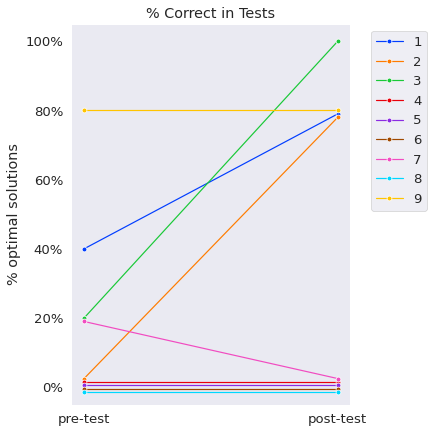

In [14]:
def plot_optimal(ax=None, save=True):
    participants = [9, 1, 2, 3, 7, 4, 5, 6, 8]
    plot_pretest_posttest(
        learn_df, participants=participants,
        # ylabel='% correct (optimal) solutions',
        ylabel='% optimal solutions',
        # title='Learning Outcomes on Optimality',
        # title='Number Correct in Tests',
        title='% Correct in Tests',
        filename='learning_outcomes_is_optimal.pdf',
        getter=lambda row: (row.pretest_optimal, row.posttest_optimal),
        ax=ax, save=save, zero_offset=+0.025  # , verbose=True,
    )


plot_optimal()

### Visualize optimal solutions by error in the tests.

../figures/learning_outcomes_error.pdf


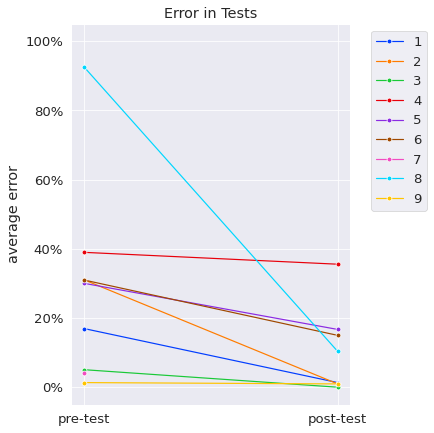

In [15]:
def plot_error(ax=None, save=True):
    participants = [2, 6, 5, 7, 4, 8, 3, 1, 9]
    plot_pretest_posttest(
        learn_df, participants=participants,
        ylabel='average error',
        # title='Learning Outcomes via Error',
        title='Error in Tests',
        filename='learning_outcomes_error.pdf',
        yticks=True, offset=-0.01,  # offset=0,
        ygrid=True,
        getter=lambda row: (row.pretest_error, row.posttest_error),
        ax=ax, save=save,
    )


plot_error()

../figures/learning_outcomes_all.pdf


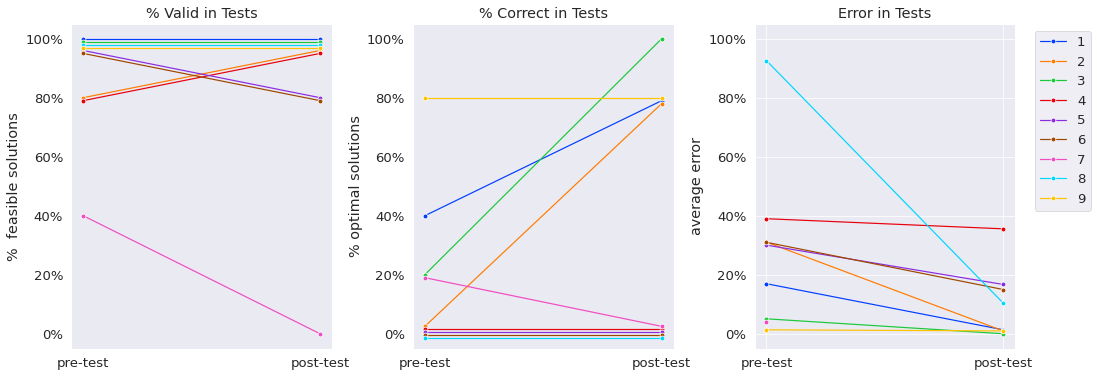

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

plot_feasible(ax=axes[0], save=False)
plot_optimal(ax=axes[1], save=False)
plot_error(ax=axes[2], save=False)

fig.tight_layout(pad=-0.1)
export_file = figs_dir.joinpath('learning_outcomes_all.pdf')
plt.savefig(export_file, bbox_inches='tight')
print(export_file)

### Perform Wilcoxon signed-rank tests and compute the effect size (estimated by Cliff's delta).

In [17]:
learn_df

,pretest_feasible,posttest_feasible,pretest_optimal,posttest_optimal,pretest_error,posttest_error
participant,,,,,,
1,1.0,1.0,0.4,0.8,0.169524,0.013333
2,0.8,1.0,0.0,0.8,0.310476,0.009524
3,1.0,1.0,0.2,1.0,0.040635,0.000000
4,0.8,1.0,0.0,0.0,0.389841,0.355556
5,1.0,0.8,0.0,0.0,0.300317,0.166984
6,1.0,0.8,0.0,0.0,0.309841,0.149841
7,0.4,0.0,0.2,0.0,0.040000,NaN
8,1.0,1.0,0.0,0.0,0.925714,0.103492
9,1.0,1.0,0.8,0.8,0.013333,0.009524


In [18]:
# categories = ['feasible', 'optimal', 'error']
categories = ['error']

df = learn_df.dropna().copy()

for category in categories:
    
    r = list(df['pretest_{}'.format(category)])
    o = list(df['posttest_{}'.format(category)])

    print(category)
    print('r:', ['{:.3f}'.format(val) for val in r])
    print('o:', ['{:.3f}'.format(val) for val in o])
    
    print('Shapiro:', shapiro(r), shapiro(o))
    # # Can not do t-test: assumption for normality are not held.
    # t, p = ttest_rel(r, o)
    # print('Exact: t={}, p={}'.format(t, p))
    
    w, p = wilcoxon(r, o, mode="exact")
    
    # Null hypothesis says they are the same:
    # if p val less than threshold, reject hypothesis. 
    # conclude that post and pre are different.
    print('Exact: W={}, p={}'.format(w, p))
    
    # a, b = wilcoxon(r, o, mode="exact", alternative="greater")
    # print('Greater: W={}, p={}'.format(a, b))

    # Estimate effect size by Cliff's Delta.
    d = two_group_difference(control=r, test=o, effect_size='cliffs_delta')
    print("Cliff's delta = {}".format(d))

error
r: ['0.170', '0.310', '0.041', '0.390', '0.300', '0.310', '0.926', '0.013']
o: ['0.013', '0.010', '0.000', '0.356', '0.167', '0.150', '0.103', '0.010']
Shapiro: ShapiroResult(statistic=0.8358798623085022, pvalue=0.0683099776506424) ShapiroResult(statistic=0.817490816116333, pvalue=0.043910637497901917)
Exact: W=0.0, p=0.0078125
Cliff's delta = -0.609375


### Save the learning outcomes table.

In [19]:
learn_df.to_csv(learning_file)
print('Saved learning outcomes table to {}'.format(learning_file))

Saved learning outcomes table to ../processed_data/justhink21_learning_outcomes.csv
